# Short-Term Forecast Results
Results and plots for 2030 strategy comparison

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import geopandas as gpd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be sl

## Imports
grab population data stored for each DA so that per capita emission can be converted to cumulative.

In [2]:
pop_da = pd.read_csv('C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/data/houses/da_pop2021.csv').set_index('DAUID')
pop_da = pop_da[~pop_da.index.duplicated(keep='first')]
pop_da

,pop_2021
DAUID,
10010165,500.0
10010166,340.0
10010167,407.0
10010168,523.0
10010169,285.0
...,...
62080024,423.0
62080025,514.0
62080026,868.0


## Re-creating short-term strategies plot
plot from ISIE conference on short-term strategies compairing BIC to matred to 2030. Can look at high vs. low growth as well

importing the forecasting results data.

In [3]:
p_r = "C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/Fig_Canada/results/short-term/"

# Normal (and Business as Usual which should both be very similar)
#baseline_bau_95q_mh
names = ['baseline_bau_95q_sf','baseline_bau_95q_mm', 'baseline_bau_95q_mh', 
         'baseline_highgrowth_95q_sf','baseline_highgrowth_95q_mm', 'baseline_highgrowth_95q_mh']
f_norms = [pd.read_csv(p_r+name+'.csv', index_col=0) for name in names]

# Best in Class Buildings
names_bic = ['bic_bau_95q_sf','bic_bau_95q_mm', 'bic_bau_95q_mh', 
             'bic_highgrowth_95q_sf','bic_highgrowth_95q_mm', 'bic_highgrowth_95q_mh']
f_bic = [pd.read_csv(p_r+name+'.csv', index_col=0) for name in names_bic]

# All infill

# Material Reductions
names_mat = ['matred_bau_95q_sf','matred_bau_95q_mm', 'matred_bau_95q_mh', 
             'matred_highgrowth_95q_sf','matred_highgrowth_95q_mm', 'matred_highgrowth_95q_mh']
f_mat = [pd.read_csv(p_r+name+'.csv', index_col=0) for name in names_mat]

# Combined Strategies
names_combi = ['bic_matred_bau_95q_sf','bic_matred_bau_95q_mm', 'bic_matred_bau_95q_mh', 
             'bic_matred_highgrowth_95q_sf','bic_matred_highgrowth_95q_mm', 'bic_matred_highgrowth_95q_mh']
f_combi = [pd.read_csv(p_r+name+'.csv', index_col=0) for name in names_combi]

group and transform into total instead of per capita

In [4]:
## Functions
def convert_ghg_megaton(res_df, pop_da):
    """
    Convert the results to absolute by multiplying
    by population, convert to tonnes from kg (e-3).
    res_df = results dataframe.
    ont_da = from Importer().
    """
    res_df = res_df.join(pop_da, on='DAUID')
    res_df['house_ghg'] = res_df['house_ghg_pp']*res_df['pop_2021']*10**-3
    res_df['road_ghg'] = res_df['road_ghg_pp']*res_df['pop_2021']*10**-3
    res_df['water_ghg'] = res_df['water_inf_ghg_pp']*res_df['pop_2021']*10**-3
    res_df = res_df.drop(['house_ghg_pp','road_ghg_pp','water_inf_ghg_pp'], axis=1)

    return res_df

    
def group_by_iter(res_df, aggr):
    """
    Group the time series results by iteration using some 
    aggregating average.
    res_df = results dataframe.
    aggr = aggregation function.
    """
    res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)

    return res_df_grouped


def group_convert(res_df, ont_da, aggr):
    res_df_c = convert_ghg_megaton(res_df, ont_da)
    res_df_g = group_by_iter(res_df_c, aggr)
    return res_df_g

In [5]:
fg_norms = [group_convert(r, pop_da, np.median) for r in f_norms]
fg_bic = [group_convert(r, pop_da, np.median) for r in f_bic]
fg_mat = [group_convert(r, pop_da, np.median) for r in f_mat]
fg_combi = [group_convert(r, pop_da, np.median) for r in f_combi]

C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function sum at 0x00000248FE77A700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function median at 0x00000248F77AC550> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function sum at 0x00000

In [6]:
fg_bic[2]#['tot_pd_check_count'].sum()

,iter,tot_pd_check_count,pop_2021,house_ghg,road_ghg,water_ghg
year,,,,,,
0,49.5,290405.0,568855.0,5.334931e+06,427393.310270,56289.194579
1,49.5,277590.0,543523.5,5.127631e+06,429705.110091,55424.486606
2,49.5,276230.0,542455.5,5.102575e+06,425522.829872,55189.897550
3,49.5,285207.5,560341.5,5.263116e+06,434169.519090,56115.549964
4,49.5,288577.5,566289.0,5.321282e+06,441942.802884,56849.895400
5,49.5,287215.0,563127.5,5.301728e+06,437629.756234,56564.662787
6,49.5,286375.0,561356.0,5.281451e+06,436341.196276,56430.376897
7,49.5,285047.5,558050.0,5.259592e+06,434348.794027,56268.572476
8,49.5,282402.5,552500.0,5.222071e+06,437329.891271,56550.921585


Combine all of the grouped results tables into one table for plotting

In [7]:
c_names = ['bau_sfq', 'bau_mmq', 'bau_mhq', 'highgrowth_sfq', 'highgrowth_mmq', 'highgrowth_mhq']

# norm
strats_norms = pd.concat([fg_norms[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(6)], axis=1)
strats_norms_d = pd.concat([fg_norms[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(6)], axis=1)
strats_norms.columns = c_names
strats_norms_d.columns = c_names

# best in class
strats_bic = pd.concat([fg_bic[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(6)], axis=1)
strats_bic_d = pd.concat([fg_bic[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(6)], axis=1)
strats_bic.columns = c_names
strats_bic_d.columns = c_names

# all infill

# material reductions
strats_mat = pd.concat([fg_mat[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(6)], axis=1)
strats_mat_d = pd.concat([fg_mat[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(6)], axis=1)
strats_mat.columns = c_names
strats_mat_d.columns = c_names
strats_norms

# combi
strats_combi = pd.concat([fg_combi[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(6)], axis=1)
strats_combi_d = pd.concat([fg_combi[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(6)], axis=1)
strats_combi.columns = c_names
strats_combi_d.columns = c_names
strats_norms

,bau_sfq,bau_mmq,bau_mhq,highgrowth_sfq,highgrowth_mmq,highgrowth_mhq
year,,,,,,
0,19.777811,8.490454,9.342259,20.717952,8.899879,9.773305
1,38.647124,16.598874,18.316333,42.157573,18.082109,19.860539
2,57.449106,24.687365,27.280806,67.401880,28.875000,31.608667
3,76.848593,33.027733,36.516525,101.395344,43.350086,47.119482
4,96.512570,41.468452,45.842274,148.166032,63.221893,68.156595
5,116.129063,49.883851,55.135959,207.427899,88.337350,94.587862
6,135.647224,58.261490,64.397530,274.718389,116.823385,124.494063
7,155.037542,66.607681,73.600986,345.775380,146.895229,156.004708
8,174.256972,74.864080,82.738981,418.259631,177.589408,188.156731


Import BAU 2030

In [8]:
pau = "C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/Fig_Canada/results/bau/"
f_bau = [pd.read_csv(pau+'bau_d_2029_2030.csv', index_col=0), pd.read_csv(pau+'bau_add_d_2029_2030.csv', index_col=0)] 

In [9]:
fg_bau = [group_convert(r, pop_da, np.median) for r in f_bau]

C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function sum at 0x00000248FE77A700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function median at 0x00000248F77AC550> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function sum at 0x00000

In [10]:
c_names_bau = ['bau_2030_expectedgrowth', 'bau_2030_highgrowth']

# norm
strats_bau = pd.concat([fg_bau[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(2)], axis=1)
strats_bau_d = pd.concat([fg_bau[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(2)], axis=1)
strats_bau.columns = c_names_bau
strats_bau_d.columns = c_names_bau
strats_bau_d

,bau_2030_expectedgrowth,bau_2030_highgrowth
year,,
0,12.677642,43.476367
1,12.566890,44.334860


Import BAU 2022-2023

In [11]:
f_bau_2022 = pd.read_csv(pau+'bau_2022_2023.csv', index_col=0)
fg_bau_2022 = group_convert(f_bau_2022, pop_da, np.median)

C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function sum at 0x00000248FE77A700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function median at 0x00000248F77AC550> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)


In [13]:
strats_bau_2022 = fg_bau_2022[['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6
strats_bau_d_2022 = fg_bau_2022[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
strats_bau_2022.columns = c_names_bau
strats_bau_d_2022.columns = c_names_bau
strats_bau_d_2022

year
0    12.80918
1    12.31389
dtype: float64

In [14]:
strats_bau_d

,bau_2030_expectedgrowth,bau_2030_highgrowth
year,,
0,12.677642,43.476367
1,12.566890,44.334860


<b>PLOTTING</b>

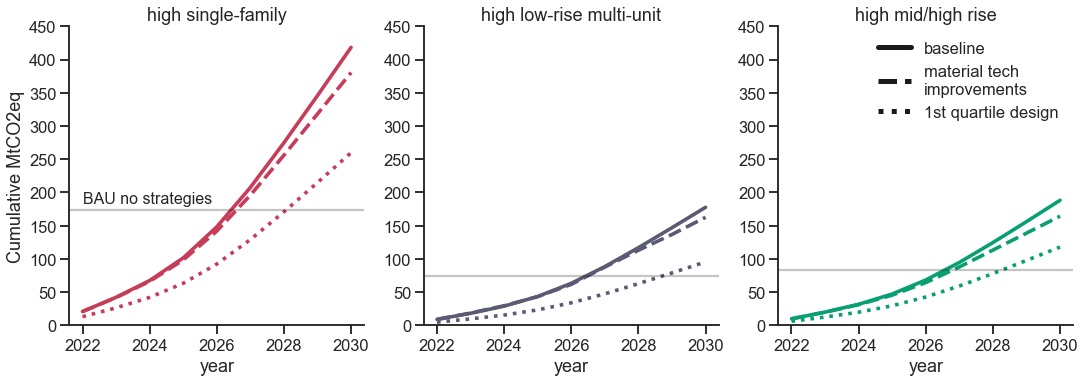

In [27]:
# plot the same plot as above but having the same housing mixes on the same plots.
fig, ax = plt.subplots(1,3, figsize=(18,5.5))
strat_colours = ['#C73C58','#5A5A72', '#32323F','#658156']
strat_colours = ['#C73C58', '#5A5A72', '#099e73']
conf_colours = ['#FF5275', '#999BC5','#6E6F8D','#7FA26E']
straa = ['#dedede','#dedede', '#dedede','#dedede']
strat_colours_s = [strat_colours, strat_colours, strat_colours]
conf_colours_s = [strat_colours, conf_colours, conf_colours]
lw = 3.6

strats = [strats_bic, strats_mat, strats_norms] #strats_combi]
strats_n = ['baseline','best-in-class design','material reductions','combined strategies']
cols_name = ['high single-family', 'high low-rise multi-unit', 'high mid/high rise']
cols = ['bau_sfq', 'bau_mmq', 'bau_mhq']
cols_hg = ['highgrowth_sfq', 'highgrowth_mmq', 'highgrowth_mhq']
linestyles = ['dotted','dashed', 'solid']

### Plot
for i, s in enumerate(strats):
    for j, c in enumerate(cols_hg):
        sns.lineplot(ax=ax.reshape(-1)[j], data=s[0:], 
                    x=np.arange(2022,2031), y=c, 
                    alpha=1, linewidth=lw, color=strat_colours_s[i][j], linestyle=linestyles[i],legend=False)
        
        
        #ax.reshape(-1)[j].fill_between(s_min[i].reset_index()['year'], s_max[i][c], s_min[i][c], 
        #               color=conf_colours[j], linewidth=0, alpha=0.5)


bau_cumulatives = [174.256972, 74.864080, 82.738981]
i = 0
for a in ax.reshape(-1):
    a.spines[['top','right']].set_visible(False)
    #a.legend(frameon=False, loc=(1.1,-0.5), fontsize=28, title='housing mix')
    a.set_ylim([0,450])
    #a.set_xlim([2022,2033])
    a.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
    #a.set_yticklabels([0, '','', 150, '', '', 300, '', '', 450])
    a.set_ylabel('')
    a.set_xlabel('year')
    a.set_title(cols_name[i], )#fontweight='bold')
    #a.grid(visible=1, axis='y', linestyle=(0, (1,5)))
    a.axhline(y=bau_cumulatives[i], color='k', linestyle='-', alpha=0.25)
    i+=1

ax[0].text(2022, bau_cumulatives[0]+10, 'BAU no strategies', fontsize=16)
ax[0].set_ylabel('Cumulative MtCO2eq')

# attempted legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=5, linestyle='solid'),
                Line2D([0], [0], color='k', lw=5, linestyle='dashed'),
                Line2D([0], [0], color='k', lw=5, linestyle='dotted'),]

ax[2].legend(custom_lines, ['baseline','material tech\nimprovements','1st quartile design'], frameon=False,
                          #loc=(0.25,-1)
                          )

<b> housing mix plot </b>

In [28]:
# Add types of houses built to results
census_info = pd.read_csv('C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/data/houses/canada_da_census_info.csv', index_col=0)
census_info = census_info.set_index('DAUID')
census_info

fgns = []
for f in f_norms:
    f = f.join(census_info[['single_detached','mid_high_rise','missing_middle']])
    fg = group_convert(f, pop_da, np.median)
    fgns.append(fg)

NameError: name 'fgns' is not defined

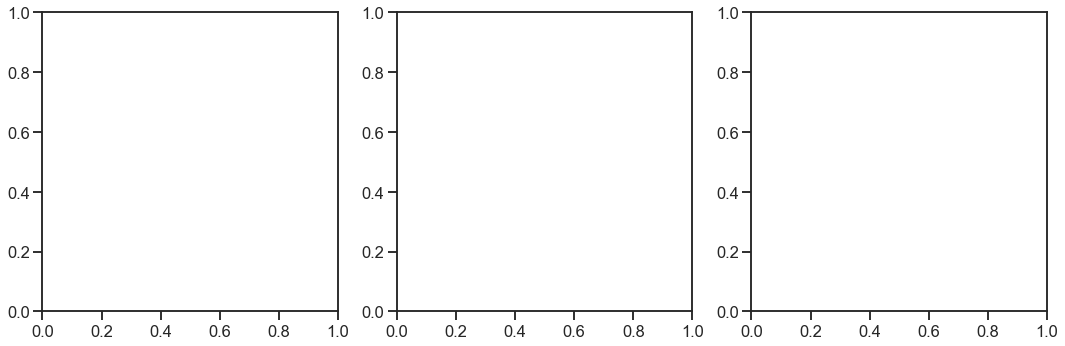

In [11]:
# plot barchart to go above the cumulative short term emissions of types of houses started
# inits
fig, ax = plt.subplots(1,3, figsize=(18,5.5))
strat_colours = ['#C73C58', '#5A5A72', '#099e73']

# loop plotting
for i, f_group_house in enumerate(fgns[3:]):
    # init barplot df
    plotr = pd.DataFrame({'house types':['single-family','low-rise-multi-unit','mid/high rise'],
                      'starts':[f_group_house['single_detached'].sum(),
                                f_group_house['missing_middle'].sum(), 
                                f_group_house['mid_high_rise'].sum()]})

    sns.barplot(ax=ax[i], data=plotr, x='house types', y='starts',
                palette=strat_colours)


# make it pretty
for a in ax.reshape(-1):
    a.set_title(cols_name[i], )
    a.spines[['top','right']].set_visible(False)
    a.set_xticklabels(labels=plotr['house types'], rotation = 45)
    a.set_xlabel('')
    a.set_ylim([0, 6000000])

plt.tight_layout()


one big plot attempt

Inset axis

Text(0.5, 1.06, 'cumulative emissions with affordability growth')

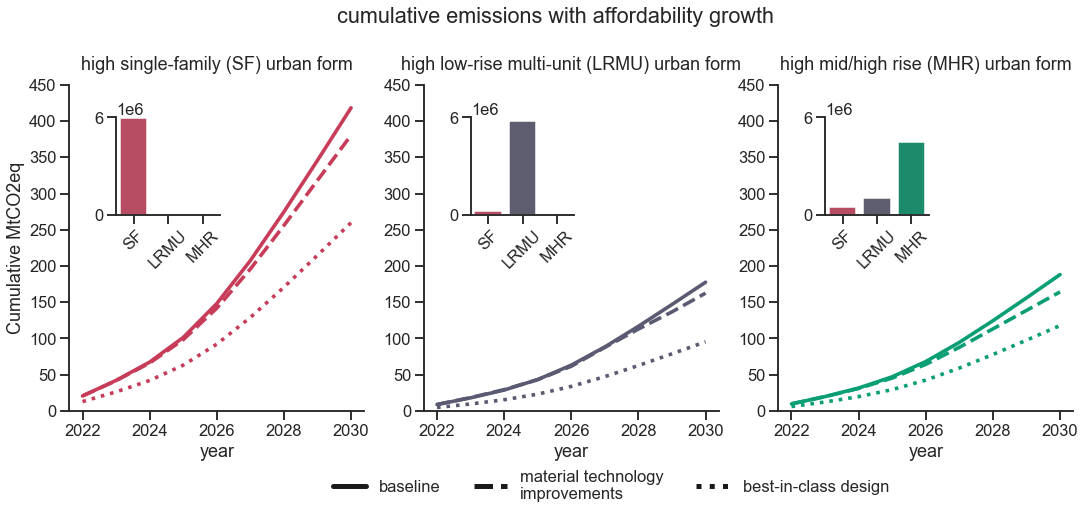

In [29]:
# plot the same plot as above but having the same housing mixes on the same plots.
fig, ax = plt.subplots(1,3, figsize=(18,6))
strat_colours = ['#C73C58','#5A5A72', '#32323F','#658156']
strat_colours = ['#C73C58', '#5A5A72', '#099e73']
conf_colours = ['#FF5275', '#999BC5','#6E6F8D','#7FA26E']
straa = ['#dedede','#dedede', '#dedede','#dedede']
strat_colours_s = [strat_colours, strat_colours, strat_colours]
conf_colours_s = [strat_colours, conf_colours, conf_colours]
lw = 3.6

strats = [strats_bic, strats_mat, strats_norms] #strats_combi]
strats_n = ['baseline','best-in-class design','material reductions','combined strategies']
cols_name = ['high single-family (SF) urban form', 'high low-rise multi-unit (LRMU) urban form', 'high mid/high rise (MHR) urban form']
cols = ['bau_sfq', 'bau_mmq', 'bau_mhq']
cols_hg = ['highgrowth_sfq', 'highgrowth_mmq', 'highgrowth_mhq']
linestyles = ['dotted','dashed', 'solid']

### Plot
for i, s in enumerate(strats):
    for j, c in enumerate(cols_hg):
        sns.lineplot(ax=ax.reshape(-1)[j], data=s[0:], 
                    x=np.arange(2022,2031), y=c, 
                    alpha=1, linewidth=lw, color=strat_colours_s[i][j], linestyle=linestyles[i],legend=False)
        
        
        #ax.reshape(-1)[j].fill_between(s_min[i].reset_index()['year'], s_max[i][c], s_min[i][c], 
        #               color=conf_colours[j], linewidth=0, alpha=0.5)


bau_cumulatives = [174.256972, 74.864080, 82.738981]
i = 0
for a in ax.reshape(-1):
    a.spines[['top','right']].set_visible(False)
    #a.legend(frameon=False, loc=(1.1,-0.5), fontsize=28, title='housing mix')
    a.set_ylim([0,450])
    #a.set_xlim([2022,2033])
    a.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
    #a.set_yticklabels([0, '','', 150, '', '', 300, '', '', 450])
    a.set_ylabel('')
    a.set_xlabel('year')
    a.set_title(cols_name[i], pad=15)#fontweight='bold')
    #a.grid(visible=1, axis='y', linestyle=(0, (1,5)))
    #a.axhline(y=bau_cumulatives[i], color='k', linestyle='-', alpha=0.25)
    i+=1

#ax[0].text(2022, bau_cumulatives[0]-30, 'House Mix BAU', fontsize=16)
#ax[1].text(2022, bau_cumulatives[1]+10, 'House Mix BAU', fontsize=16)
#ax[2].text(2022, bau_cumulatives[2]+10, 'House Mix BAU', fontsize=16)
ax[0].set_ylabel('Cumulative MtCO2eq')

# attempted legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=5, linestyle='solid'),
                Line2D([0], [0], color='k', lw=5, linestyle='dashed'),
                Line2D([0], [0], color='k', lw=5, linestyle='dotted'),]

ax[1].legend(custom_lines, ['baseline','material technology\nimprovements','best-in-class design'], frameon=False,
                          loc=(-0.33, -0.3), ncol=3
                          )

## INSET AXIS
for i, a in enumerate(ax.flat):
    ins = a.inset_axes([0.16,0.6,0.35,0.3])

    plotr = pd.DataFrame({'house types':['SF','LRMU','MHR'],
                      'starts':[fgns[3+i]['single_detached'].sum(),
                                fgns[3+i]['missing_middle'].sum(), 
                                fgns[3+i]['mid_high_rise'].sum()]})

    sns.barplot(ax=ins, data=plotr, x='house types', y='starts',
                palette=strat_colours)

    #ins.set_title(cols_name[i])
    ins.spines[['top','right']].set_visible(False)
    ins.set_xticklabels(labels=plotr['house types'], rotation = 45)
    ins.set_xlabel('')
    ins.set_ylabel('')
    ins.set_ylim([0, 6000000])
    ins.set_yticks([0, 6*10**6])

plt.suptitle('cumulative emissions with affordability growth', y=1.06)
#plt.savefig('plt2a.svg', bbox_inches='tight')

#### Simpler plots showing the above
for presentations

Text(0.5, 1.0, 'Growth to restore housing affordability')

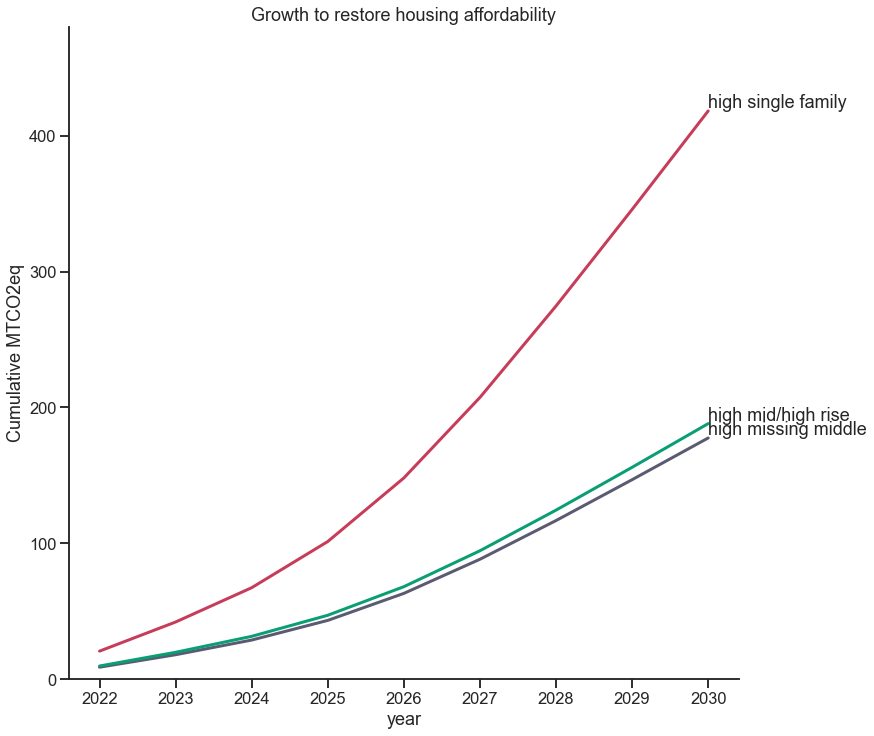

In [56]:
strats = [strats_bic, strats_mat, strats_norms] #strats_combi]
strat_colours = ['#C73C58', '#5A5A72', '#099e73']
strats_n = ['baseline','best-in-class design','material reductions','combined strategies']
cols_name = ['high single family','high missing middle','high mid/high rise']
cols = ['bau_sfq', 'bau_mmq', 'bau_mhq']
cols_hg = ['highgrowth_sfq', 'highgrowth_mmq', 'highgrowth_mhq']
linestyles = ['dotted','dashed', 'solid']

fig, a = plt.subplots(figsize=(12,12))

for i, c in enumerate(cols_hg):
    sns.lineplot(ax=a, x=np.arange(2022,2031), y=strats_norms[c], color=strat_colours[i], linewidth=3)
    a.annotate(xy=(2030,strats_norms[c][8]+2), text=cols_name[i])

# Options
a.spines[['top','right']].set_visible(False)
a.set_ylim([0,480])
a.set_ylabel('Cumulative MTCO2eq')
a.set_xlabel('year')
a.set_title('Growth to restore housing affordability')


simple graph: ghg savings mat tech vs. denser housing

In [63]:
s_saves = []
for c in cols_hg:
    # BIC savings
    s_saves.append(strats[2][c][8] - strats[0][c][8])
    # mat improvement savings
    s_saves.append(strats[2][c][8] - strats[1][c][8])

x_labs = ['Savings from']

In [64]:
s_saves

[158.47433656771642,
 37.84040506058267,
 82.21736588497723,
 15.04139048242493,
 70.37240305484272,
 23.907118713753192]

Below I calculate some summary statistics needed for the body of the text

In [30]:
# Emissions range in scenarios
print('top mix (high SF, affordability growth) ', strats_norms[8:]['highgrowth_sfq'])
print('bot mix (high LRMU, affordability growth) ', strats_norms[8:]['highgrowth_mmq'])

# difference between high growth and BAU
print('single family mix: ', strats_norms[8:]['highgrowth_sfq']-strats_norms[8:]['bau_sfq'])
print('mm mix: ', strats_norms[8:]['highgrowth_mmq']-strats_norms[8:]['bau_mmq'])
print('mid high mix: ', strats_norms[8:]['highgrowth_mhq']-strats_norms[8:]['bau_mhq'])

# percent difference
print('single family %: ', (strats_norms[8:]['highgrowth_sfq']-strats_norms[8:]['bau_sfq'])/strats_norms[8:]['highgrowth_sfq'])
print('mm %: ', (strats_norms[8:]['highgrowth_mmq']-strats_norms[8:]['bau_mmq'])/strats_norms[8:]['highgrowth_mmq'])
print('mid high %: ', (strats_norms[8:]['highgrowth_mhq']-strats_norms[8:]['bau_mhq'])/strats_norms[8:]['highgrowth_mhq'])

top mix (high SF, affordability growth)  year
8    418.259631
Name: highgrowth_sfq, dtype: float64
bot mix (high LRMU, affordability growth)  year
8    177.589408
Name: highgrowth_mmq, dtype: float64
single family mix:  year
8    244.002659
dtype: float64
mm mix:  year
8    102.725328
dtype: float64
mid high mix:  year
8    105.41775
dtype: float64
single family %:  year
8    0.583376
dtype: float64
mm %:  year
8    0.578443
dtype: float64
mid high %:  year
8    0.560266
dtype: float64


In [65]:
# savings from moving away from entirely single family
a = strats_norms['highgrowth_sfq'][8] - strats_norms['highgrowth_mmq'][8]
print('max savings from form shift, ', a)
print('%', a/strats_norms['highgrowth_sfq'][8])
strats_norms

# material reduction potential
b = strats_norms['highgrowth_sfq'][8] - strats_mat['highgrowth_sfq'][8]
c = strats_norms['highgrowth_sfq'][8] - strats_bic['highgrowth_sfq'][8]
print(b)
print(c)
print('material savings', b/strats_norms['highgrowth_sfq'][8])
print('design savings', c/strats_norms['highgrowth_sfq'][8])

max savings from form shift,  240.67022340369837
% 0.5754086824713829
37.84040506058267
158.47433656771642
material savings 0.09047109074050383
design savings 0.3788898681371105


### SI Plot: the cumulative emissions with affordability growth plot but with variability shown
along with a simple function for calculating the confidence interval of our simulation

In [64]:
def confidence_interval(res_df, pop_da, num_years=9):
    """ Calculates 95% confidence interval over 
    the iterations and years for the expected value."""

    # convert to absolute ghg
    grouped_df = convert_ghg_megaton(res_df, pop_da)
    grouped_df = grouped_df.groupby(['year','iter']).sum().reset_index()

    ci_ranges = []
    for y in range(num_years):
        year_emit = grouped_df[grouped_df['year'] == y][['house_ghg','road_ghg','water_ghg']].sum(axis=1) * 10**-6
        ci_ranges.append(1.96*np.std(year_emit, ddof=1)/np.sqrt(year_emit.shape[0]))

    return ci_ranges
    

In [69]:
f_norms_ci = [confidence_interval(r, pop_da) for r in f_norms]
f_bic_ci = [confidence_interval(r, pop_da) for r in f_bic]
f_mat_ci = [confidence_interval(r, pop_da) for r in f_mat]

In [90]:
f_norms_ci_df = pd.DataFrame(np.array(f_norms_ci).T, columns=c_names)
f_bic_ci_df = pd.DataFrame(np.array(f_bic_ci).T, columns=c_names)
f_mat_ci_df = pd.DataFrame(np.array(f_mat_ci).T, columns=c_names)
f_norms_ci_df

,bau_sfq,bau_mmq,bau_mhq,highgrowth_sfq,highgrowth_mmq,highgrowth_mhq
0,0.020200,0.012845,0.021075,0.022663,0.012399,0.020193
1,0.019098,0.010205,0.020066,0.020173,0.014121,0.022305
2,0.018399,0.012421,0.021099,0.020721,0.015371,0.022697
3,0.018450,0.013519,0.019627,0.020591,0.013637,0.022781
4,0.019361,0.013527,0.022290,0.020991,0.017422,0.024407
5,0.017934,0.014134,0.023675,0.023765,0.016652,0.026772
6,0.019700,0.013677,0.022140,0.024533,0.017491,0.028284
7,0.020777,0.013525,0.023371,0.027122,0.015815,0.027233
8,0.019638,0.011874,0.022340,0.025700,0.014790,0.026057


In [13]:
#strats_norms_d.add(f_norms_ci_df).cumsum()

below plots the min and max simulations - less rigorous way of doing it

In [31]:
# Running this generates the required min and max results
print('grouping')
fg_norms_min = [group_convert(r, pop_da, np.min) for r in f_norms]
fg_bic_min = [group_convert(r, pop_da, np.min) for r in f_bic]
fg_mat_min = [group_convert(r, pop_da, np.min) for r in f_mat]

fg_norms_max = [group_convert(r, pop_da, np.max) for r in f_norms]
fg_bic_max = [group_convert(r, pop_da, np.max) for r in f_bic]
fg_mat_max = [group_convert(r, pop_da, np.max) for r in f_mat]

fs_min = [fg_bic_min, fg_mat_min, fg_norms_min]
fs_max = [fg_bic_max, fg_mat_max, fg_norms_max]

s_min = []
s_max = []

print('stratting')
for f in fs_min:
    strats_f = pd.concat([f[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(6)], axis=1)
    strats_f.columns = c_names
    s_min.append(strats_f)

for f in fs_max:
    strats_f = pd.concat([f[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(6)], axis=1)
    strats_f.columns = c_names
    s_max.append(strats_f)

grouping
stratting


In [32]:
print(s_min[0]['highgrowth_mhq'])
print(s_max[0]['highgrowth_mhq'])

year
0      5.887595
1     12.008706
2     19.099285
3     28.525026
4     41.413423
5     57.644547
6     76.119870
7     95.600451
8    115.459917
Name: highgrowth_mhq, dtype: float64
year
0      6.266858
1     12.798923
2     20.394430
3     30.342111
4     43.838216
5     60.722118
6     79.744298
7     99.793935
8    120.261550
Name: highgrowth_mhq, dtype: float64


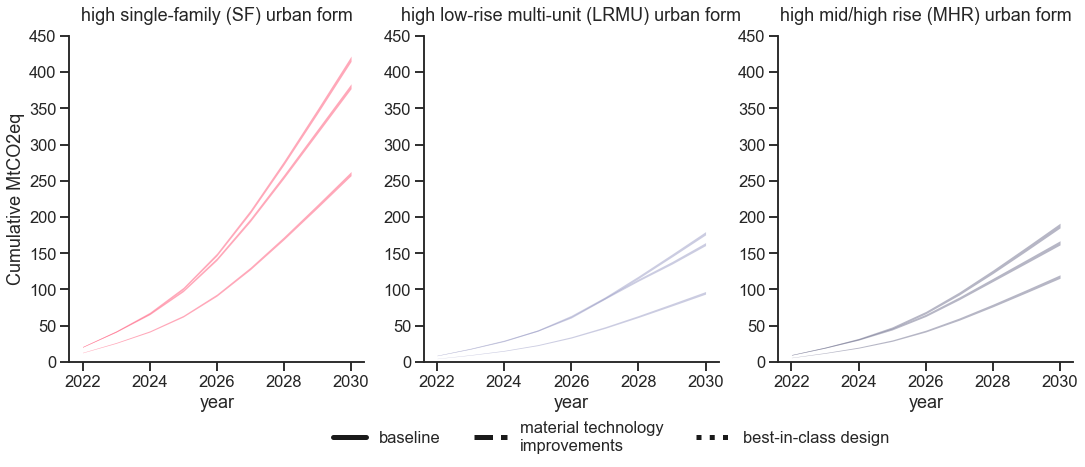

In [33]:
# plot the same plot as above but having the same housing mixes on the same plots.
fig, ax = plt.subplots(1,3, figsize=(18,6))
strat_colours = ['#C73C58','#5A5A72', '#32323F','#658156']
strat_colours = ['#C73C58', '#5A5A72', '#099e73']
conf_colours = ['#FF5275', '#999BC5','#6E6F8D','#7FA26E']
straa = ['#dedede','#dedede', '#dedede','#dedede']
strat_colours_s = [strat_colours, strat_colours, strat_colours]
conf_colours_s = [strat_colours, conf_colours, conf_colours]
lw = 3.6

strats = [strats_bic, strats_mat, strats_norms] #strats_combi]
strats_n = ['baseline','best-in-class design','material reductions','combined strategies']
cols_name = ['high single-family (SF) urban form', 'high low-rise multi-unit (LRMU) urban form', 'high mid/high rise (MHR) urban form']
cols = ['bau_sfq', 'bau_mmq', 'bau_mhq']
cols_hg = ['highgrowth_sfq', 'highgrowth_mmq', 'highgrowth_mhq']
linestyles = ['dotted','dashed', 'solid']

### Plot
for i, s in enumerate(strats):
    for j, c in enumerate(cols_hg):
        #sns.lineplot(ax=ax.reshape(-1)[j], data=s[0:], 
        #            x=np.arange(2022,2031), y=c, 
        #            alpha=1, linewidth=lw, color=strat_colours_s[i][j], linestyle=linestyles[i],legend=False)
        
        
        ax.reshape(-1)[j].fill_between(np.arange(2022,2031), s_max[i][c], s_min[i][c], 
                       color=conf_colours[j], linewidth=0, alpha=0.5)


bau_cumulatives = [174.256972, 74.864080, 82.738981]
i = 0
for a in ax.reshape(-1):
    a.spines[['top','right']].set_visible(False)
    #a.legend(frameon=False, loc=(1.1,-0.5), fontsize=28, title='housing mix')
    a.set_ylim([0,450])
    #a.set_xlim([2022,2033])
    a.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450])
    #a.set_yticklabels([0, '','', 150, '', '', 300, '', '', 450])
    a.set_ylabel('')
    a.set_xlabel('year')
    a.set_title(cols_name[i], pad=15)#fontweight='bold')
    #a.grid(visible=1, axis='y', linestyle=(0, (1,5)))
    #a.axhline(y=bau_cumulatives[i], color='k', linestyle='-', alpha=0.25)
    i+=1

#ax[0].text(2022, bau_cumulatives[0]-30, 'House Mix BAU', fontsize=16)
#ax[1].text(2022, bau_cumulatives[1]+10, 'House Mix BAU', fontsize=16)
#ax[2].text(2022, bau_cumulatives[2]+10, 'House Mix BAU', fontsize=16)
ax[0].set_ylabel('Cumulative MtCO2eq')

# attempted legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=5, linestyle='solid'),
                Line2D([0], [0], color='k', lw=5, linestyle='dashed'),
                Line2D([0], [0], color='k', lw=5, linestyle='dotted'),]

ax[1].legend(custom_lines, ['baseline','material technology\nimprovements','best-in-class design'], frameon=False,
                          loc=(-0.33, -0.3), ncol=3
                          )

## Federal reduction goal plot
re-creating the emission reduction barplot where I look at the yearly reduction potential of each strategy to see if you can get below the federal goal linearly downscaled. We need a 2022 baseline emissions calculation within our model using the % of houses built in 2022 in each province ugh. Or assume open. <b>ADD ERROR BARS</b>

In [16]:
strats_mat_d
strats_bau_d

,bau_2030_expectedgrowth,bau_2030_highgrowth
year,,
0,12.677642,43.476367
1,12.566890,44.334860


In [17]:
strats_combi

,bau_sfq,bau_mmq,bau_mhq,highgrowth_sfq,highgrowth_mmq,highgrowth_mhq
year,,,,,,
0,12.305816,4.510746,5.828434,12.937533,4.734562,6.093032
1,23.908785,8.755893,11.285405,26.092576,9.547698,12.230375
2,35.287956,12.917378,16.601511,41.352289,15.115723,19.182962
3,46.839253,17.114192,21.919877,61.507150,22.453981,28.162063
4,58.344243,21.277698,27.150468,88.806817,32.351346,39.968989
5,69.641660,25.359436,32.223552,122.809212,44.629807,54.348260
6,80.710292,29.333472,37.133875,160.755318,58.286449,70.095692
7,91.524592,33.191803,41.871834,200.165461,72.390273,86.172843
8,102.069938,36.928148,46.464469,239.673614,86.462159,102.024683


-11.742012709111577


Text(1.6, 11, 'federal 2030 reduction target')

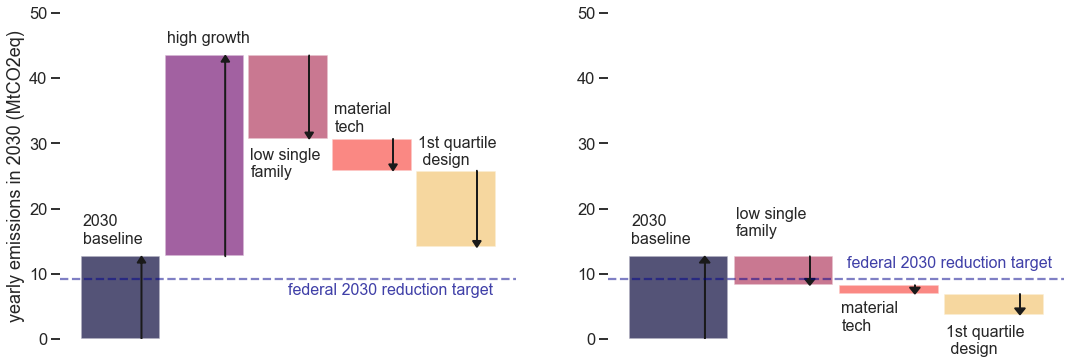

In [18]:
# calcs HIGH GROWTH
xs = ['BAU','High Growth','Shift to LRMU','material technology','1st quartile design']
bau = strats_bau_d['bau_2030_expectedgrowth'][0]
highgrowth = strats_bau_d['bau_2030_highgrowth'][0]#(strats_norms_d['highgrowth_sfq'][8]+strats_norms_d['highgrowth_mmq'][8])/2
lrmu = (strats_norms_d['highgrowth_mmq'][8])
mat_tech = (strats_mat_d['highgrowth_mmq'][8])
best_design = (strats_combi_d['highgrowth_mmq'][8])
print(best_design-mat_tech)
# bottom of barchart
bottoms = [0, bau, highgrowth, lrmu, mat_tech]
# height calculate from different in adding strategies (one ahead of sum of bottoms essentially)
heights = [bau, highgrowth-bau, lrmu-highgrowth, mat_tech-lrmu, best_design-mat_tech]


# calcs BAU
xs_bau = ['BAU','Shift to LRMU','material technology','1st quartile design']
lrmu_bau = (strats_norms_d['bau_mmq'][8])
mat_tech_bau = (strats_mat_d['bau_mmq'][8])
best_design_bau = (strats_combi_d['bau_mmq'][8])
bottoms_bau = [0, bau, lrmu_bau, mat_tech_bau]
heights_bau = [bau, lrmu_bau-bau, mat_tech_bau-lrmu_bau, best_design_bau-mat_tech_bau]


# calculate linearly downscaled 40% target
# "Canada's national inventory report said 610Mt in 2021, assume this is the same in 2022. We need to get down to 511/443 by 2030 and then assume straight line to net zero from there."
percent = (610-443)/610
reduction_target = bau*(1-percent)

# Inits
fig, ax = plt.subplots(1,2,figsize=(18,6))
colours= ["#0c0a3e","#7b1e7a","#b33f62","#f9564f","#f3c677"]
colours_bau= ["#0c0a3e","#b33f62","#f9564f","#f3c677"]
#colours = ['#241023', '#6b0504', '#a3320b', '#d5e68d', '#47a025']
#colours_bau = ['#241023', '#a3320b', '#d5e68d', '#47a025']

# Plot
ax[0].bar(x=xs, bottom=bottoms, height=heights, 
          width=0.95, color=colours, alpha=0.7)
ax[1].bar(x=xs_bau, bottom=bottoms_bau, height=heights_bau, 
          width=0.95, color=colours_bau, alpha=0.7)

ax[0].axhline(y=reduction_target, color='darkblue', linestyle='dashed', alpha=0.5)
ax[1].axhline(y=reduction_target, color='darkblue', linestyle='dashed', alpha=0.5)


# Options
ax[0].set_ylim([0,50])
ax[0].spines[['top','right','left','bottom']].set_visible(False)
#ax[0].grid(visible=1, axis='y', linestyle=(0, (1,15)))
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('yearly emissions in 2030 (MtCO2eq)')
#ax[0].set_title('with high construction growth')

ax[1].set_ylim([0,50])
ax[1].spines[['top','right','left','bottom']].set_visible(False)
#ax[1].grid(visible=1, axis='y', linestyle=(0, (1,15)))
ax[1].get_xaxis().set_visible(False)
#ax[1].set_title('with business as usual growth')
#ax[1].get_yaxis().set_visible(False)
#ax[1].set_yticklabels([])

# arrows and text
texts = ['2030\nbaseline', 'high growth', 'low single \nfamily', 'material \ntech', '1st quartile\n design']
texts_1 = ['2030\nbaseline', 'low single \nfamily', 'material \ntech', '1st quartile\n design']
j = 2
jitters_0 = [j, j, -2.9*j, 3*j, 6.3*j]
jitters_1 = [j, 3.8*j, -2.8*j, -3*j]
for i in range(0, 5):
    ax[0].arrow(i+0.25, bottoms[i], 0, heights[i], color='k', 
                head_width=0.1, 
                head_length=1, length_includes_head=True,
                )
    ax[0].text(i-0.45, heights[i]+bottoms[i]+jitters_0[i], texts[i], fontsize=16)
    
    if i <=3:
        ax[1].arrow(i+0.25, bottoms_bau[i], 0, heights_bau[i], color='k', 
                    head_width=0.1, 
                    head_length=1, length_includes_head=True,
                    )
        ax[1].text(i-0.45, heights_bau[i]+bottoms_bau[i]+jitters_1[i], texts_1[i], fontsize=16)

ax[0].text(2, 6.8, 'federal 2030 reduction target', fontsize=16, color='darkblue', alpha=0.75)
ax[1].text(1.6, 11, 'federal 2030 reduction target', fontsize=16, color='darkblue', alpha=0.75)

#plt.tight_layout()
#plt.savefig('fig 2b.svg', bbox_inches='tight')

Below is the same graph but adding circularity and infill. Recalculate the 2030 infill and circularity sensitvity numbers by just reducing the number of houses built in the sensitvity file <br>
the first cell imports the 100% infill and double circularity simulations, the second cell plots the waterfall plot

In [15]:
names_infill = ['bic_matred_bau_95q_mm_allinf','bic_matred_highgrowth_95q_mm_allinf',
         'bic_matred_bau_95q_mm_allinf_doublec','bic_matred_highgrowth_95q_mm_allinf_doublec']
f_all_inf = [pd.read_csv(p_r+name+'.csv', index_col=0) for name in names_infill]

fg_all_inf = [group_convert(r, pop_da, np.median) for r in f_all_inf]

C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function sum at 0x00000248FE77A700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function median at 0x00000248F77AC550> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_22768\2404693984.py:25: FutureWarning: The provided callable <function sum at 0x00000

In [16]:
c_names = ['all_infill_bau','all_infill_highgrowth','double_c_bau','double_c_highgrowth']
strats_all_inf = pd.concat([fg_all_inf[i][['house_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(4)], axis=1)
strats_all_inf_d = pd.concat([fg_all_inf[i][['house_ghg']].sum(axis=1)*10**-6 for i in range(4)], axis=1)
strats_all_inf.columns = c_names
strats_all_inf_d.columns = c_names

In [17]:
strats_all_inf_d

,all_infill_bau,all_infill_highgrowth,double_c_bau,double_c_highgrowth
year,,,,
0,3.506712,3.679194,1.778354,1.862585
1,3.285124,3.732911,1.663452,1.890580
2,3.217988,4.320696,1.630022,2.180380
3,3.243825,5.684205,1.645330,2.857220
4,3.221349,7.643094,1.636035,3.853052
5,3.154385,9.504906,1.597717,4.771538
6,3.070777,10.569705,1.555578,5.303519
7,2.979004,10.907571,1.512409,5.473925
8,2.887854,10.879310,1.466363,5.456090


In [18]:
strats_all_inf

,all_infill_bau,all_infill_highgrowth,double_c_bau,double_c_highgrowth
year,,,,
0,3.506712,3.679194,1.778354,1.862585
1,6.791837,7.412105,3.441806,3.753165
2,10.009825,11.732801,5.071828,5.933544
3,13.253650,17.417006,6.717158,8.790764
4,16.474999,25.060101,8.353194,12.643816
5,19.629384,34.565007,9.950911,17.415354
6,22.700160,45.134712,11.506489,22.718873
7,25.679164,56.042282,13.018898,28.192798
8,28.567018,66.921592,14.485262,33.648888


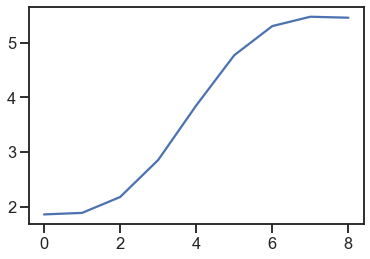

In [31]:
plt.plot(strats_all_inf_d['double_c_highgrowth'])

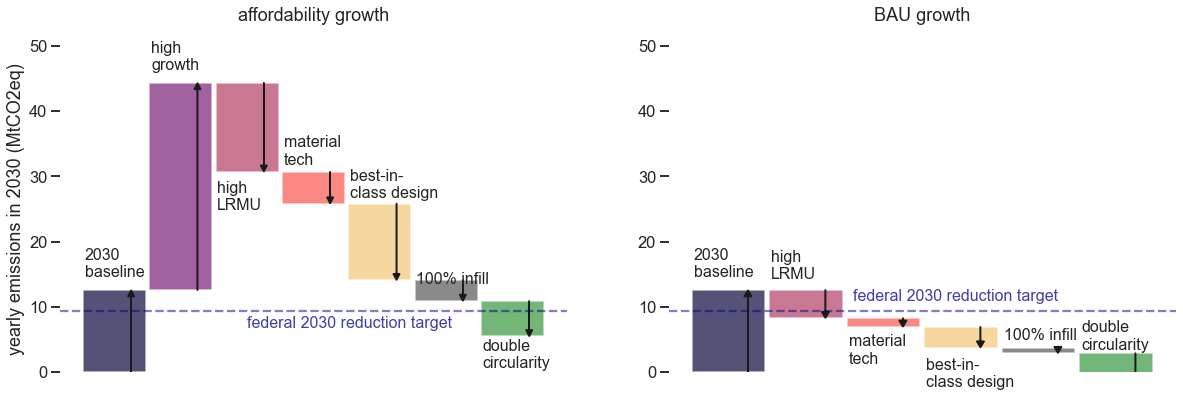

In [36]:
# calcs HIGH GROWTH
xs = ['BAU','High Growth','Shift to LRMU','material technology','1st quartile design','infill','circular']
bau = strats_bau_d['bau_2030_expectedgrowth'][1]
highgrowth = strats_bau_d['bau_2030_highgrowth'][1]#(strats_norms_d['highgrowth_sfq'][8]+strats_norms_d['highgrowth_mmq'][8])/2
lrmu = (strats_norms_d['highgrowth_mmq'][8])
mat_tech = (strats_mat_d['highgrowth_mmq'][8])
best_design = (strats_combi_d['highgrowth_mmq'][8])
#The number below comes from the best-case sensitivity analysis in k_sensitivity.ipynb -> 2030 best case scenario -> commented out
all_infill = strats_all_inf_d['all_infill_highgrowth'][8]#(12.335728461077071)
double_circular = strats_all_inf_d['double_c_highgrowth'][8]#(6.192022)
# bottom of barchart
bottoms = [0, bau, highgrowth, lrmu, mat_tech, 
           best_design, all_infill]
# height calculate from different in adding strategies (one ahead of sum of bottoms essentially)
heights = [bau, highgrowth-bau, lrmu-highgrowth, mat_tech-lrmu, best_design-mat_tech,
           all_infill-best_design, double_circular-all_infill]


# calcs BAU
xs_bau = ['BAU','Shift to LRMU','material technology','1st quartile design','infill','circular']
lrmu_bau = (strats_norms_d['bau_mmq'][8])
mat_tech_bau = (strats_mat_d['bau_mmq'][8])
best_design_bau = (strats_combi_d['bau_mmq'][8])
# also from k_sensitvity.ipynb 2030 best-case scenario -> commented out
all_infill_bau = strats_all_inf_d['all_infill_bau'][8]#(3.1788882042007964)
double_circular_bau = strats_all_inf_d['double_c_bau'][8]#(1.600941)

bottoms_bau = [0, bau, lrmu_bau, mat_tech_bau,
               best_design_bau, all_infill_bau]
heights_bau = [bau, lrmu_bau-bau, mat_tech_bau-lrmu_bau, best_design_bau-mat_tech_bau,
               all_infill_bau-best_design_bau, double_circular_bau-all_infill]


# calculate linearly downscaled 40% target
# "Canada's national inventory report said 610Mt in 2021, assume this is the same in 2022. We need to get down to 511/443 by 2030 and then assume straight line to net zero from there."
percent = (610-443)/610
reduction_target = strats_bau_d_2022[0]*(1-percent)

# Inits
fig, ax = plt.subplots(1,2,figsize=(20,6))
colours= ["#0c0a3e","#7b1e7a","#b33f62","#f9564f","#f3c677",'#565758','#38983F']
colours_bau= ["#0c0a3e","#b33f62","#f9564f","#f3c677",'#565758','#38983F']
#colours = ['#241023', '#6b0504', '#a3320b', '#d5e68d', '#47a025']
#colours_bau = ['#241023', '#a3320b', '#d5e68d', '#47a025']

# Plot
ax[0].bar(x=xs, bottom=bottoms, height=heights, 
          width=0.95, color=colours, alpha=0.7)
ax[1].bar(x=xs_bau, bottom=bottoms_bau, height=heights_bau, 
          width=0.95, color=colours_bau, alpha=0.7)

ax[0].axhline(y=reduction_target, color='darkblue', linestyle='dashed', alpha=0.5)
ax[1].axhline(y=reduction_target, color='darkblue', linestyle='dashed', alpha=0.5)


# Options
ax[0].set_ylim([0,50])
ax[0].spines[['top','right','left','bottom']].set_visible(False)
#ax[0].grid(visible=1, axis='y', linestyle=(0, (1,15)))
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('yearly emissions in 2030 (MtCO2eq)')
ax[0].set_title('affordability growth', pad=25)

ax[1].set_ylim([0,50])
ax[1].spines[['top','right','left','bottom']].set_visible(False)
#ax[1].grid(visible=1, axis='y', linestyle=(0, (1,15)))
ax[1].get_xaxis().set_visible(False)
ax[1].set_title('BAU growth', pad=25)
#ax[1].get_yaxis().set_visible(False)
#ax[1].set_yticklabels([])

# arrows and text
texts = ['2030\nbaseline', 'high \ngrowth', 'high \nLRMU', 'material \ntech', 'best-in-\nclass design', '100% infill', 'double\ncircularity']
texts_1 = ['2030\nbaseline', 'high \nLRMU', 'material \ntech', 'best-in-\nclass design', '100% infill', 'double\ncircularity']
j = 2
jitters_0 = [j, j, -2.9*j, 3*j, 6.3*j, 1.3*j, -2.4*j]
jitters_1 = [j, 3*j, -2.8*j, -3*j, j, 5*j]
for i in range(0, 7):
    ax[0].arrow(i+0.25, bottoms[i], 0, heights[i], color='k', 
                head_width=0.1, 
                head_length=1, length_includes_head=True,
                )
    ax[0].text(i-0.45, heights[i]+bottoms[i]+jitters_0[i], texts[i], fontsize=16)
    
    if i <=5:
        ax[1].arrow(i+0.25, bottoms_bau[i], 0, heights_bau[i], color='k', 
                    head_width=0.1, 
                    head_length=1, length_includes_head=True,
                    )
        ax[1].text(i-0.45, heights_bau[i]+bottoms_bau[i]+jitters_1[i], texts_1[i], fontsize=16)

ax[0].text(2, 6.8, 'federal 2030 reduction target', fontsize=16, color='darkblue', alpha=0.75)
ax[1].text(1.6, 11, 'federal 2030 reduction target', fontsize=16, color='darkblue', alpha=0.75)

#plt.savefig('plt2b_extended_fixed.svg', bbox_inches='tight')

In [38]:
reduction_target-double_circular

3.84631434451102

-- random stats and results below as asked by shoshanna --

In [12]:
strats_norms

,bau_sfq,bau_mmq,bau_mhq,highgrowth_sfq,highgrowth_mmq,highgrowth_mhq
year,,,,,,
0,19.777811,8.490454,9.342259,20.717952,8.899879,9.773305
1,38.647124,16.598874,18.316333,42.157573,18.082109,19.860539
2,57.449106,24.687365,27.280806,67.401880,28.875000,31.608667
3,76.848593,33.027733,36.516525,101.395344,43.350086,47.119482
4,96.512570,41.468452,45.842274,148.166032,63.221893,68.156595
5,116.129063,49.883851,55.135959,207.427899,88.337350,94.587862
6,135.647224,58.261490,64.397530,274.718389,116.823385,124.494063
7,155.037542,66.607681,73.600986,345.775380,146.895229,156.004708
8,174.256972,74.864080,82.738981,418.259631,177.589408,188.156731


In [22]:
print(bau*1.3)
print(highgrowth*1.3)
print(double_circular*1.3)

print(bau*1.3-double_circular*1.3)
print(highgrowth*1.3-bau*1.3)

16.336957312465856
57.63531747228105
8.0432378
8.293719512465856
41.298360159815196


In [83]:
print(strats_bau_d['bau_2030_highgrowth'][1]/strats_norms_d['highgrowth_sfq'][8])
print(strats_bau_d['bau_2030_highgrowth'][0]/strats_norms_d['highgrowth_sfq'][7])
print(strats_bau_d['bau_2030_expectedgrowth'][1]/strats_norms_d['bau_sfq'][8])

a=strats_bau_d['bau_2030_highgrowth'][1]/strats_norms_d['highgrowth_sfq'][8]
b=strats_bau_d['bau_2030_expectedgrowth'][1]/strats_norms_d['bau_sfq'][8]
c = (a+b)/2
c

0.6116481704235481
0.6118520657408467
0.6538638380286453


0.6327560042260967

Coming up with a way of interpolating the cumulative emissions for scenarios where we only did 2029-2030

In [85]:
print(bau*1.3/(strats_norms['bau_sfq'][8]*c*1.3))
print(highgrowth*1.3/(strats_norms['highgrowth_sfq'][8]*c*1.3))

0.11397284354468219
0.16751862984831895


In [106]:
print('baseline interpolate cumulative h growth (INCORRECT NUMBER)', strats_bau_d['bau_2030_highgrowth'][1]/0.1135)
print('baseline downscaling norms cumulative 100% single family', strats_norms['highgrowth_sfq'][8]*0.6116481704235481)
print('baseline interpolate cumulative bau growth', strats_bau_d['bau_2030_expectedgrowth'][1]/0.1135)
print('baseline interpolate cumulative bau growth', strats_norms['bau_sfq'][8]*0.6116481704235481)
print('best case interpolate cumulative', (double_circular)/0.1135)
print('best case interpolate cumulative', (double_circular_bau)/0.1135)
#print('best case interpolate cumulative', double_circular*0.6116481704235481)

baseline interpolate cumulative h growth (INCORRECT NUMBER) 390.61550303138625
baseline downscaling norms cumulative 100% single family 255.82773827473443
baseline interpolate cumulative bau growth 110.72149991505152
baseline interpolate cumulative bau growth 106.58395814040121
best case interpolate cumulative 54.55525991189427
best case interpolate cumulative 14.10520704845815


In [97]:
# Cumulative interpolation of above - 30% increase to account for bottom-up
print(strats_norms['bau_sfq'][8]*c*1.3)
print(strats_norms['highgrowth_sfq'][8]*c*1.3)
print((double_circular*1.3)/0.1135)

print((strats_norms['bau_sfq'][8]*c*1.3) - ((double_circular*1.3)/0.1135))
print((strats_norms['highgrowth_sfq'][8]*c*1.3) - (strats_norms['bau_sfq'][8]*c*1.3))

143.34078894908922
344.053180977348
70.86553127753304
72.47525767155618
200.7123920282588


In [57]:
print(strats_norms['highgrowth_sfq'][8])

418.2596313458787


In [54]:
foo = f_bau[0].copy()
foo_s = foo[foo['year'] == 0].groupby('iter').sum()
print(foo_s[['house_ghg_pp', 'road_ghg_pp', 'water_inf_ghg_pp']].sum(axis=1).max())
print(foo_s[['house_ghg_pp', 'road_ghg_pp', 'water_inf_ghg_pp']].sum(axis=1).min())
foo_s

23853549.749299698
21053814.997590143


,house_ghg_pp,road_ghg_pp,water_inf_ghg_pp,tot_pd_check_count,single_detached,missing_middle,mid_high_rise,year
iter,,,,,,,,
0,2.044830e+07,2.061447e+06,219111.451846,294360.0,106765.0,122945.0,60650.0,0
1,2.002281e+07,1.777974e+06,208651.263072,290510.0,105265.0,121335.0,58840.0,0
2,2.110029e+07,2.171509e+06,233824.755271,296790.0,108075.0,122595.0,60190.0,0
3,2.073071e+07,1.946268e+06,221503.699716,292440.0,107305.0,119790.0,60680.0,0
4,1.982602e+07,1.906470e+06,217827.316948,296115.0,108030.0,121425.0,61200.0,0
...,...,...,...,...,...,...,...,...
95,2.057163e+07,1.915451e+06,218848.843890,293330.0,105915.0,123355.0,59745.0,0
96,2.112466e+07,2.494213e+06,234680.402301,294155.0,107090.0,121285.0,61495.0,0
97,2.067633e+07,2.094902e+06,227431.602392,294565.0,106340.0,122575.0,61340.0,0


Summary statistics - Results

In [21]:
# exceeding in baseline scenario.
#bau_2022 = strats_bau_d_2022[0]
print('percent exceeded')
print((bau-reduction_target)/reduction_target)
print((highgrowth-reduction_target)/reduction_target)
print('absolute')
print((bau-reduction_target))
print((highgrowth-reduction_target))

# mitigation gap
print('actual number Mt gaps')
print(reduction_target-double_circular)

# conclusions
print('some old stuff i think:')
print(strats_combi_d['highgrowth_mmq'][8]-reduction_target)
print((strats_combi_d['highgrowth_mmq'][8]-reduction_target)/bau)

percent exceeded
0.3509292758716667
3.7659571001052035
absolute
3.2644859881077988
35.0324553418118
actual number Mt gaps
3.1103822522505506
some old stuff i think:
4.769482529149673
0.3795276665847342


Summary stats for discussion 4.1

In [18]:
(strats_norms['highgrowth_sfq'].loc[8] - strats_bic['highgrowth_mmq'].loc[8])/strats_norms['highgrowth_sfq'].loc[8]

0.7719788501933255

Checks

In [38]:
print(highgrowth)
print(reduction_target)

44.334859594062344
9.126446518817621


min and max affordability growth baseline

In [35]:
fg_baumax = [group_convert(r, pop_da, np.max) for r in f_bau]
strats_bau_dmax = pd.concat([fg_baumax[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(2)], axis=1)
strats_bau_dmax.columns = c_names_bau

fg_baumin = [group_convert(r, pop_da, np.min) for r in f_bau]
strats_bau_dmin = pd.concat([fg_baumin[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(2)], axis=1)
strats_bau_dmin.columns = c_names_bau


In [36]:
strats_bau_dmax

,bau_2030_expectedgrowth,bau_2030_highgrowth
year,,
0,12.945008,43.788197
1,12.783635,44.699961


In [37]:
print(strats_bau_dmax['bau_2030_highgrowth'][1])
print(strats_bau_dmin['bau_2030_highgrowth'][1])
strats_bau_d['bau_2030_highgrowth'][1]

44.69996097205355
44.03325885836864


44.334859594062344

Plotting the min and max for the bars in the 2030 strategies plot

In [75]:
# Running this generates the required min and max results
print('grouping')
fg_norms_min = [group_convert(r, pop_da, np.min) for r in f_norms]
fg_bic_min = [group_convert(r, pop_da, np.min) for r in f_bic]
fg_mat_min = [group_convert(r, pop_da, np.min) for r in f_mat]
fg_combi_min = [group_convert(r, pop_da, np.min) for r in f_combi]

fg_norms_max = [group_convert(r, pop_da, np.max) for r in f_norms]
fg_bic_max = [group_convert(r, pop_da, np.max) for r in f_bic]
fg_mat_max = [group_convert(r, pop_da, np.max) for r in f_mat]
fg_combi_max = [group_convert(r, pop_da, np.max) for r in f_combi]

fs_min = [fg_bic_min, fg_mat_min, fg_norms_min, fg_combi_min]
fs_max = [fg_bic_max, fg_mat_max, fg_norms_max, fg_combi_max]

s_min_d = []
s_max_d = []

print('stratting')
for f in fs_min:
    strats_f_d = pd.concat([f[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(6)], axis=1)
    strats_f_d.columns = c_names
    s_min_d.append(strats_f_d)

for f in fs_max:
    strats_f_d = pd.concat([f[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(6)], axis=1)
    strats_f_d.columns = c_names
    s_max_d.append(strats_f_d)

grouping
stratting


In [76]:
# calcs HIGH GROWTH
xs = ['BAU','High Growth','Shift to LRMU','material technology','1st quartile design','infill','circular']
bau = strats_bau_d['bau_2030_expectedgrowth'][1]
bau_min = strats_bau_dmin['bau_2030_expectedgrowth'][1]
bau_max = strats_bau_dmax['bau_2030_expectedgrowth'][1]

highgrowth = strats_bau_d['bau_2030_highgrowth'][1]
highgrowth_min = strats_bau_dmin['bau_2030_highgrowth'][1]
highgrowth_max = strats_bau_dmax['bau_2030_highgrowth'][1]


lrmu = (strats_norms_d['highgrowth_mmq'][8])
lrmu_min = (s_min_d[2]['highgrowth_mmq'][8])
lrmu_max = (s_max_d[2]['highgrowth_mmq'][8])

mat_tech = (strats_mat_d['highgrowth_mmq'][8])
mat_tech_min = (s_min_d[1]['highgrowth_mmq'][8])
mat_tech_max = (s_max_d[1]['highgrowth_mmq'][8])

best_design = (strats_combi_d['highgrowth_mmq'][8])
best_design_min = (s_min_d[3]['highgrowth_mmq'][8])
best_design_max = (s_max_d[3]['highgrowth_mmq'][8])


#The number below comes from the best-case sensitivity analysis in k_sensitivity.ipynb
all_infill = (12.335728461077071)
all_infill_min = (12.1)
all_infill_max = (12.5)
double_circular = (6.187106)
double_circular_min = (6.0)
double_circular_max = (6.3)

# bottom of barchart
bottoms = [0, bau, highgrowth, lrmu, mat_tech, 
           best_design, all_infill]
# height calculate from different in adding strategies (one ahead of sum of bottoms essentially)
heights = [bau, highgrowth-bau, lrmu-highgrowth, mat_tech-lrmu, best_design-mat_tech,
           all_infill-best_design, double_circular-all_infill]

# simple barchart
heights_simp = [bau, highgrowth, lrmu, mat_tech, best_design, all_infill, double_circular]
heights_simp_min = [bau_min, highgrowth_min, lrmu_min, mat_tech_min, best_design_min, all_infill_min, double_circular_min]
heights_simp_max = [bau_max, highgrowth_max, lrmu_max, mat_tech_max, best_design_max, all_infill_max, double_circular_max]

heights_top = np.array(heights_simp_max) - np.array(heights_simp)
heights_bot = np.array(heights_simp) - np.array(heights_simp_min)


# calcs BAU
xs_bau = ['BAU','Shift to LRMU','material technology','1st quartile design']
lrmu_bau = (strats_norms_d['bau_mmq'][8])
mat_tech_bau = (strats_mat_d['bau_mmq'][8])
best_design_bau = (strats_combi_d['bau_mmq'][8])
bottoms_bau = [0, bau, lrmu_bau, mat_tech_bau]
heights_bau = [bau, lrmu_bau-bau, mat_tech_bau-lrmu_bau, best_design_bau-mat_tech_bau]
heights_bau_simp = [bau, lrmu_bau, mat_tech_bau, best_design_bau]

In [78]:
heights_bot

array([0.2675286 , 0.30160074, 0.28204842, 0.22628018, 0.20348021,
       0.23572846, 0.187106  ])

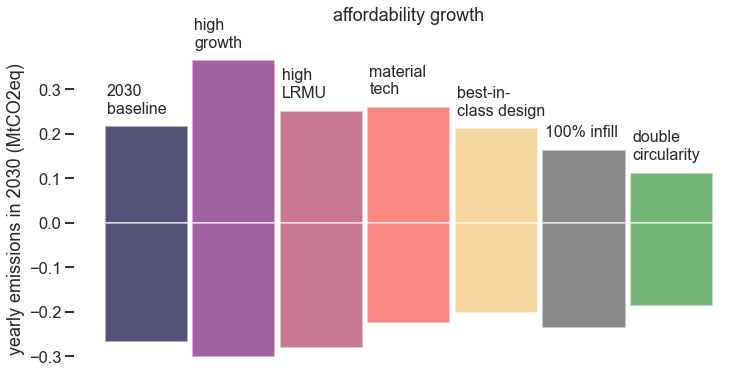

In [92]:
# Inits
fig, ax = plt.subplots(figsize=(12,6))
colours= ["#0c0a3e","#7b1e7a","#b33f62","#f9564f","#f3c677",'#565758','#38983F']
colours_bau= ["#0c0a3e","#b33f62","#f9564f","#f3c677"]
#colours = ['#241023', '#6b0504', '#a3320b', '#d5e68d', '#47a025']
#colours_bau = ['#241023', '#a3320b', '#d5e68d', '#47a025']

# Plot
#ax.bar(x=xs, height=heights_simp, 
#          width=0.95, color=colours, alpha=0.7)
ax.bar(x=xs, height=heights_top, 
          width=0.95, color=colours, alpha=0.7)
ax.bar(x=xs, height=-heights_bot, 
          width=0.95, color=colours, alpha=0.7)
#ax[1].bar(x=xs_bau, height=heights_bau_simp, 
#          width=0.95, color=colours_bau, alpha=0.7)

#ax.axhline(y=reduction_target, color='darkblue', linestyle='dashed', alpha=0.5)
#ax[1].axhline(y=reduction_target, color='darkblue', linestyle='dashed', alpha=0.5)

#ax.errorbar(x=xs, y=heights_simp, yerr=(heights_top, heights_bot), fmt=".", color='r')


# Options
#ax.set_ylim([0,50])
ax.spines[['top','right','left','bottom']].set_visible(False)
#ax[0].grid(visible=1, axis='y', linestyle=(0, (1,15)))
ax.get_xaxis().set_visible(False)
ax.set_ylabel('yearly emissions in 2030 (MtCO2eq)')
ax.set_title('affordability growth', pad=25)

# arrows and text
texts = ['2030\nbaseline', 'high \ngrowth', 'high \nLRMU', 'material \ntech', 'best-in-\nclass design', '100% infill', 'double\ncircularity']
texts_1 = ['2030\nbaseline', 'high \nLRMU', 'material \ntech', '1st quartile\n design']
j = 2
jitters_0 = [j, j, -2.9*j, 3*j, 6.3*j, 1.3*j, -2.4*j]
jitters_1 = [j, 3*j, -2.8*j, -3*j]
for i in range(0, 7):
    ax.text(i-0.45, heights_top[i]+ 0.03, texts[i], fontsize=16)
    


#ax.text(2, 6.8, 'federal 2030 reduction target', fontsize=16, color='darkblue', alpha=0.75)
#ax[1].text(1.6, 11, 'federal 2030 reduction target', fontsize=16, color='darkblue', alpha=0.75)

#plt.savefig('plt2b.svg', bbox_inches='tight')

In [48]:
heights

[12.56689024035835,
 31.767969353703997,
 -13.640680803340068,
 -4.880279300210475,
 -11.742012709111577,
 -1.7361583203231525,
 -6.148622461077071]

# ================================================================================================

## Per Province Emissions
Breaking down the emissions by province, showing the short term and long term emissions

In [52]:
#['baseline_bau_95q_sf','baseline_bau_95q_mm', 'baseline_bau_95q_mh', 'baseline_highgrowth_95q_sf','baseline_highgrowth_95q_mm', 'baseline_highgrowth_95q_mh']
# Init code
full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  ]
codes = [10,11,12,13,24,35,46,47,48,59]
p_map = dict(zip(codes, full_name_list))

# alternate grouping - atlantic quebec ontairo praries bc
g_name_list = ['atlantic','atlantic', 'atlantic', 'atlantic', 'quebec', 'ontario',
               'prarie', 'prarie', 'alberta', 'british_columbia']
p_map_g = dict(zip(codes, g_name_list))

# loop through each province and store
f_norms_prov = []
for f in f_norms:
    f['prov'] = f.index.astype(str).map(lambda x: x[:2])
    f = convert_ghg_megaton(f, pop_da)
    f['prov_g'] = f['prov'].astype(int).map(p_map_g)

    f_norms_prov.append(f)

In [7]:
# group by province and store in dict
norms_d = {}
for p in codes:
    f_norm_prov_p = [] 
    for f in f_norms_prov:
        prov_norms = f[f['prov'].astype(int) == p]
        f_norm_prov_p.append(prov_norms)
    
    norms_d[p] = f_norm_prov_p

In [53]:
# group by province and store in dict
norms_d_g = {}
for p in g_name_list:
    f_norm_prov_p = [] 
    for f in f_norms_prov:
        prov_norms = f[f['prov_g'] == p]
        f_norm_prov_p.append(prov_norms)
    
    norms_d_g[p] = f_norm_prov_p

In [51]:
# first code = province, second code = scenario
norms_d[35][0]

,iter,tot_pd_check_count,year,prov,pop_2021,house_ghg,road_ghg,water_ghg
DAUID,,,,,,,,
35240738,0,165.0,0,35,576.0,11555.039492,602.475360,262.616243
35200384,0,180.0,0,35,508.0,11872.612091,544.552133,172.469638
35370785,0,90.0,0,35,359.0,5590.187429,4455.854536,101.023379
35580435,0,175.0,0,35,505.0,12078.556779,1987.462444,85.374474
35260112,0,180.0,0,35,489.0,12460.367309,771.161693,201.180043
...,...,...,...,...,...,...,...,...
35250241,99,95.0,8,35,294.0,4784.610002,0.000000,0.000000
35320159,99,195.0,8,35,585.0,10587.166701,0.000000,0.000000
35160189,99,355.0,8,35,907.0,18883.687993,0.000000,0.000000


In [76]:
# store max scenario (max iter single family), min scenario (min iter mm)
prov_max_s_bas = {}
prov_min_s_bas = {}

prov_max_s_hg = {}
prov_min_s_hg = {}

for prov in codes:
    # cmhc bau growth
    pmaxb = norms_d[prov][0].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.max) # last agg is max or min for sf or mm
    pminb = norms_d[prov][1].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.min)

    # high growth
    pmaxhg = norms_d[prov][3].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.max)
    pminhg = norms_d[prov][4].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.min)


    prov_max_s_bas[prov] = pmaxb
    prov_min_s_bas[prov] = pminb

    prov_max_s_hg[prov] = pmaxhg
    prov_min_s_hg[prov] = pminhg

In [54]:
# alternative grouping
# store max scenario (max iter single family), min scenario (min iter mm)
prov_max_s_bas = {}
prov_min_s_bas = {}

prov_max_s_hg = {}
prov_min_s_hg = {}

for prov in g_name_list:
    # cmhc bau growth
    pmaxb = norms_d_g[prov][0].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.max) # last agg is max or min for sf or mm
    pminb = norms_d_g[prov][1].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.min)

    # high growth
    pmaxhg = norms_d_g[prov][3].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.max)
    pminhg = norms_d_g[prov][4].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.min)


    prov_max_s_bas[prov] = pmaxb
    prov_min_s_bas[prov] = pminb

    prov_max_s_hg[prov] = pmaxhg
    prov_min_s_hg[prov] = pminhg

In [78]:
len(prov_max_s_bas)

6

Summary stats for 3.2.2

In [61]:
#foo = norms_d[10][0].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.max) # last agg is max or min for range
#foo[['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6

ont_m = prov_max_s_hg['ontario'][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6
ont_b = prov_max_s_bas['ontario'][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6
print(ont_m.loc[8] - ont_b.loc[8])

ab_m = prov_max_s_hg['alberta'][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6
ab_b = prov_max_s_bas['alberta'][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6
print(ab_m.loc[8] - ab_b.loc[8])

127.38965683285352
1.4068660347224942


Plot

KeyError: 10

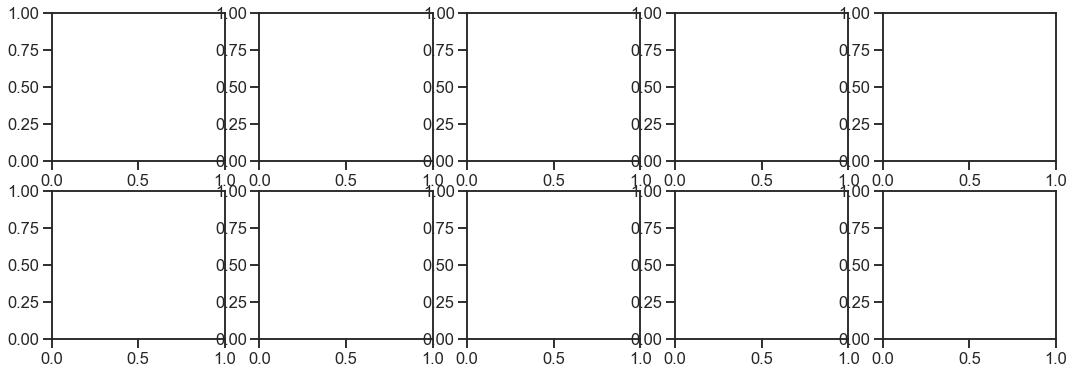

In [99]:
fig, ax = plt.subplots(2, 5, figsize=(18,6))

for i, a in enumerate(ax.reshape(-1)):
    # plot max to test, should be a fill between
    #sns.lineplot(ax=a, x=np.arange(2022, 2031), y=prov_max_s_bas[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6)
    #sns.lineplot(ax=a, x=np.arange(2022, 2031), y=prov_min_s_bas[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6)

    a.fill_between(x=np.arange(2022, 2031), 
                   y1=prov_max_s_bas[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                   y2=prov_min_s_bas[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                   color='blue', alpha=0.4
                  )

    a.set_ylim([0,60])
    a.set_xlim([2021.7,2030.5])

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(18,6))

for i, a in enumerate(ax.reshape(-1)):
    # plot max to test, should be a fill between
    #sns.lineplot(ax=a, x=np.arange(2022, 2031), y=prov_max_s_bas[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6)
    #sns.lineplot(ax=a, x=np.arange(2022, 2031), y=prov_min_s_bas[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6)

    a.fill_between(x=np.arange(2022, 2031), 
                   y1=prov_max_s_hg[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                   y2=prov_min_s_hg[codes[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                   color='red', alpha=0.4
                   )

    #a.set_ylim([0,200])
    a.set_xlim([2021.7,2030.5])

Grouped geography plots

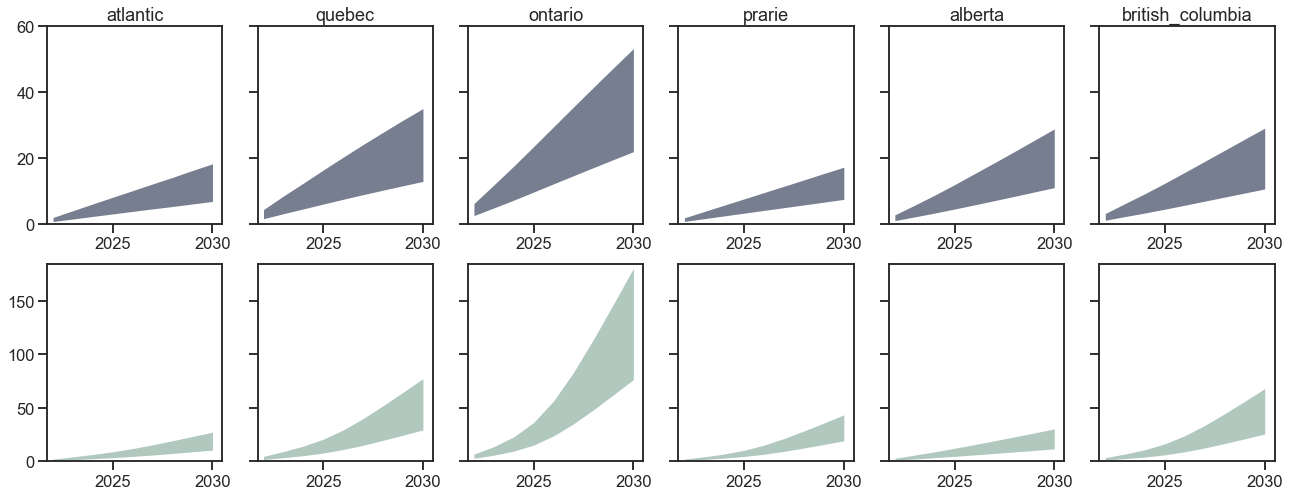

In [153]:
fig, ax = plt.subplots(2, 6, figsize=(22,8))

g_name_list_unique = ['atlantic','quebec','ontario','prarie','alberta','british_columbia']
for i, a in enumerate(ax.reshape(-1)):
    if i <= 5:
        a.fill_between(x=np.arange(2022, 2031), 
                   y1=prov_max_s_bas[g_name_list_unique[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                   y2=prov_min_s_bas[g_name_list_unique[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                   color='#545E75', alpha=0.8, linewidth=0
                   )

        a.set_ylim([0,60])
        a.set_title(g_name_list_unique[i])

    else:
        a.fill_between(x=np.arange(2022, 2031), 
                    y1=prov_max_s_hg[g_name_list_unique[i-6]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                    y2=prov_min_s_hg[g_name_list_unique[i-6]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                    color='#9DBBAE', alpha=0.8, linewidth=0
                    )

        a.set_ylim([0,185])
    a.set_xlim([2021.7,2030.5])

for i in range(6):
    if i>0:
        ax[0,i].set_yticklabels([])
        ax[1,i].set_yticklabels([])

#plt.tight_layout()

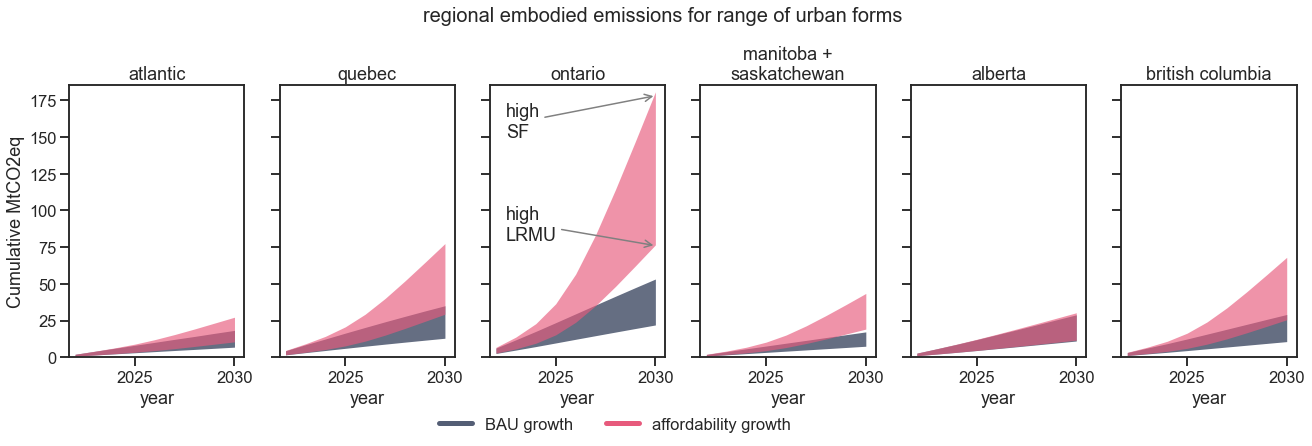

In [365]:
fig, ax = plt.subplots(1, 6, figsize=(22,5))

g_name_list_unique = ['atlantic','quebec','ontario','prarie','alberta','british_columbia']
for i, a in enumerate(ax.reshape(-1)):

    a.fill_between(x=np.arange(2022, 2031), 
                y1=prov_max_s_bas[g_name_list_unique[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                y2=prov_min_s_bas[g_name_list_unique[i]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                color='#545E75', alpha=0.9, linewidth=0
                )

    #a.set_ylim([0,60])
    a.set_title(g_name_list_unique[i])

    a.fill_between(x=np.arange(2022, 2031), 
                y1=prov_max_s_hg[g_name_list_unique[i-6]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                y2=prov_min_s_hg[g_name_list_unique[i-6]][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6,
                color='#E75A7C', alpha=0.65, linewidth=0
                )

    a.set_ylim([0,185])
    a.set_xlim([2021.7,2030.5])
    a.set_xlabel('year')
    
tit = ['atlantic','quebec','ontario','manitoba +\nsaskatchewan','alberta','british columbia']
for i in range(6):
    if i>0:
        ax[i].set_yticklabels([])
        ax[i].set_yticklabels([])

    else:
        ax[i].set_ylabel('Cumulative MtCO2eq')

    ax[i].set_title(tit[i])


# attempted legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#545E75', lw=5, linestyle='solid'),
                Line2D([0], [0], color='#E75A7C', lw=5, linestyle='solid'),
                ]

ax[2].legend(custom_lines, ['BAU growth','affordability growth'], frameon=False,
                          loc=(-0.33, -0.3), ncol=2
                          )

#ax[2].text(x=2026.5, y=100, s='high SF', rotation=65, fontsize=14)
ax[2].annotate(text='high\nSF', xy=(2030, 178), xytext=(2022.5,150), arrowprops=dict(arrowstyle='->',color='grey')) #(2027.8, 110)
ax[2].annotate(text='high\nLRMU', xy=(2030, 76), xytext=(2022.5,80), arrowprops=dict(arrowstyle='->',color='grey')) #(2029.2, 65)
plt.suptitle('regional embodied emissions for range of urban forms', y=1.1, fontsize=20)

#plt.tight_layout()
#plt.savefig('shorterm_prov_fig_anno.svg', bbox_inches='tight')

Compare strategy effectiveness by province

In [62]:
# Best in Class Buildings
# f_mat, f_bic

def prov_store(f_x):
    """encode prov info for any given imported forecast data"""
    # init
    full_name_list = ['newfoundland','nova_scotia','new_brunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british_columbia',
                  ]
    codes = [10,11,12,13,24,35,46,47,48,59]
    p_map = dict(zip(codes, full_name_list))

    # loop through each province and store
    f_prov = []
    for f in f_x:
        f['prov'] = f.index.astype(str).map(lambda x: x[:2])
        f = convert_ghg_megaton(f, pop_da)
        f['prov_g'] = f['prov'].astype(int).map(p_map)

        f_prov.append(f)

    # group by province and store in dict
    x_d = {}
    for p in codes:
        f_x_prov_p = [] 
        for f in f_prov:
            prov_x = f[f['prov'].astype(int) == p]
            f_x_prov_p.append(prov_x)
        
        x_d[p] = f_x_prov_p

    return x_d

In [63]:
bic_d = prov_store(f_bic)

In [64]:
mat_d = prov_store(f_mat)

In [65]:
#0 is bau growth 1 is high growth
bau_d = prov_store(f_bau)

In [230]:
baseline = bau_d[13][1].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
baseline_cum = baseline[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
baseline_cum_l = baseline_cum.loc[1]



formr = norms_d[13][5].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
formr_cum = formr[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6

((baseline_cum_l - formr_cum.loc[8])/baseline_cum_l)*100

print(formr_cum)
baseline_cum_l

year
0    0.403373
1    0.396157
2    0.404502
3    0.410952
4    0.404306
5    0.406449
6    0.404279
7    0.405673
8    0.407193
dtype: float64


0.3810728407534321

In [223]:
# first code = province, second code = scenario
#['baseline_bau_95q_sf','baseline_bau_95q_mm', 'baseline_bau_95q_mh', 'baseline_highgrowth_95q_sf','baseline_highgrowth_95q_mm', 'baseline_highgrowth_95q_mh']
# check effect of each strategy per province -> scenario 5 highgrowth high mm
bic_l = []
mat_l = []
form_l = []
form_mh = []
bbb = []

for prov in codes:
    # HIGH GROWTH code 3, normal growth code 0
    #baseline = norms_d[prov][0].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    #baseline_cum = baseline[['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6
    #baseline_cum_l = baseline_cum.loc[8]

    # business as usual perhaps!
    baseline = bau_d[prov][1].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    baseline_cum = baseline[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    baseline_cum_l = baseline_cum.loc[1]

    # best-in-class savings code 0 or 3
    bic = bic_d[prov][3].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    bic_cum = bic[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    # percentage savings
    bic_cum = ((baseline_cum_l-bic_cum.loc[8])/baseline_cum_l)*100

    # mat technology savings code 0 or 3
    mat = mat_d[prov][3].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    mat_cum = mat[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    # percentage savings
    mat_cum = ((baseline_cum_l-mat_cum.loc[8])/baseline_cum_l)*100

    # form savings missing middle code 1 or 4
    formr = norms_d[prov][4].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    formr_cum = formr[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    # percentage savings
    formr_cum = ((baseline_cum_l-formr_cum.loc[8])/baseline_cum_l)*100

    # form savings mid high rise code 2 or 5
    formrmh = norms_d[prov][5].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    formrmh_cum = formrmh[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    # percentage savings
    formrmh_cum = ((baseline_cum_l-formrmh_cum.loc[8])/baseline_cum_l)*100

    
    bic_l.append(bic_cum)
    mat_l.append(mat_cum)
    form_l.append(formr_cum)
    form_mh.append(formrmh_cum)

    bbb.append(baseline_cum_l)



this block below is the same as the cell above but runs for bau instead of affordability growth

In [238]:
# first code = province, second code = scenario
#['baseline_bau_95q_sf','baseline_bau_95q_mm', 'baseline_bau_95q_mh', 'baseline_highgrowth_95q_sf','baseline_highgrowth_95q_mm', 'baseline_highgrowth_95q_mh']
# check effect of each strategy per province -> scenario 5 highgrowth high mm
bic_l2 = []
mat_l2 = []
form_l2 = []
form_mh2 = []
bbb2 = []

for prov in codes:
    # HIGH GROWTH code 3, normal growth code 0
    #baseline = norms_d[prov][0].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    #baseline_cum = baseline[['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6
    #baseline_cum_l = baseline_cum.loc[8]

    # business as usual perhaps!
    baseline = bau_d[prov][0].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    baseline_cum = baseline[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    baseline_cum_l = baseline_cum.loc[1]

    # form savings missing middle code 1 or 4
    formr = norms_d[prov][1].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    formr_cum = formr[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    # percentage savings
    formr_cum = ((baseline_cum_l-formr_cum.loc[8])/baseline_cum_l)*100

    # form savings mid high rise code 2 or 5
    formrmh = norms_d[prov][2].groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(np.median)
    formrmh_cum = formrmh[['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6
    # percentage savings
    formrmh_cum = ((baseline_cum_l-formrmh_cum.loc[8])/baseline_cum_l)*100

    form_l2.append(formr_cum)
    form_mh2.append(formrmh_cum)

    bbb2.append(baseline_cum_l)


In [227]:
form_mh

[4.718103824724638,
 18.05679808094678,
 35.72850211249962,
 -6.854366000268247,
 23.041937357214522,
 32.02766485226219,
 32.834164011014686,
 -8.650664240493718,
 31.623545660839103,
 29.33869088684398]

In [80]:
import matplotlib.ticker as mtick

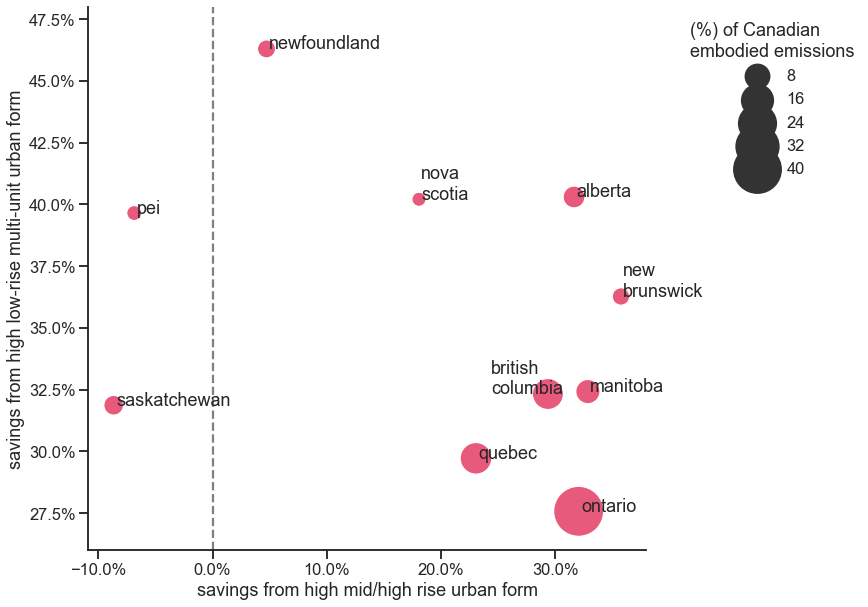

In [268]:
# nice province name list
p_list_nice = ['newfoundland','nova\nscotia','new\nbrunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british\ncolumbia',]

# create df of comparisons
prov_compare_strat = pd.DataFrame({'prov':codes, 'prov_n':p_list_nice, 
                                   'bic_save':bic_l, 'mat_save':mat_l, 'form_save_mm':form_l, 'form_save_mh':form_mh,
                                   'cumulative emissions':bbb,
                                   })
prov_compare_strat['cumulative emissions p'] = prov_compare_strat['cumulative emissions']/prov_compare_strat['cumulative emissions'].sum(axis=0)*100

fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(ax=ax, data=prov_compare_strat, x='form_save_mh', y='form_save_mm',
                size='cumulative emissions p', sizes=(200, 2500), 
                color='#E75A7C')

#ax.set_ylim([0,10])
#ax.set_xlim([0,10])

# options
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.spines[['top','right']].set_visible(False)

ax.set_ylim([26,48])
#ax.set_xlim([])

ax.set_ylabel('savings from high low-rise multi-unit urban form')
ax.set_xlabel('savings from high mid/high rise urban form')
ax.legend(frameon=False, bbox_to_anchor=(1.4,1), 
          title='(%) of Canadian\nembodied emissions')

# Label points
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if i == 9:
            ax.text(point['x']-5, point['y'], str(point['val']))
        else:
            ax.text(point['x']+.2, point['y'], str(point['val']))

# v line at intecept
ax.vlines(x=0, ymin=26, ymax=48, color='grey', linestyles='--')


label_point(prov_compare_strat['form_save_mh'], prov_compare_strat['form_save_mm'], prov_compare_strat['prov_n'], ax)

In [47]:
# nice province name list
p_list_nice = ['newfoundland','nova\nscotia','new\nbrunswick','pei','quebec','ontario',
                  'manitoba','saskatchewan','alberta','british\ncolumbia',]

# create df of comparisons
prov_compare_strat = pd.DataFrame({'prov':codes, 'prov_n':p_list_nice, 
                                   'bic_save':bic_l, 'mat_save':mat_l, 'form_save_mm':form_l, 'form_save_mh':form_mh,
                                   'cumulative emissions':bbb,
                                   })
# create df of comparisons
prov_compare_strat2 = pd.DataFrame({'prov':codes, 'prov_n':p_list_nice, 
                                   'form_save_mm':form_l2, 'form_save_mh':form_mh2,
                                   'cumulative emissions':bbb2,
                                   })


prov_compare_strat['cumulative emissions p'] = prov_compare_strat['cumulative emissions']/prov_compare_strat['cumulative emissions'].sum(axis=0)*100
prov_compare_strat2['cumulative emissions p'] = prov_compare_strat2['cumulative emissions']/prov_compare_strat2['cumulative emissions'].sum(axis=0)*100

fig, ax = plt.subplots(1,2, figsize=(17,8))

sns.scatterplot(ax=ax[0], data=prov_compare_strat, x='form_save_mh', y='form_save_mm',
                size='cumulative emissions p', sizes=(200, 6000), size_norm=(0,100),
                color='#E75A7C', s=500)

sns.scatterplot(ax=ax[1], data=prov_compare_strat2, x='form_save_mh', y='form_save_mm',
                size='cumulative emissions p', sizes=(200, 6000), size_norm=(0,100), 
                color='#545E75', s=500, alpha=0.7)

#ax.set_ylim([0,10])
#ax.set_xlim([0,10])

# options
for a in ax.reshape(-1):
    a.xaxis.set_major_formatter(mtick.PercentFormatter())
    a.yaxis.set_major_formatter(mtick.PercentFormatter())
    #a.spines[['top','right']].set_visible(False)
    a.legend(frameon=False, bbox_to_anchor=(1.2,0.5), 
          title='(%) of Canadian\nembodied emissions')

    a.set_ylim([26,48])
    a.set_xlim([-11, 39])
    a.get_legend().remove()
    #ax.set_xlim([])
    a.set_xlabel('savings from shift to mid/high rise urban form')
    a.set_ylabel('savings from shift to low-rise multi-unit urban form')

#ax.set_ylabel('savings from high low-rise multi-unit urban form')
#ax.set_xlabel('savings from high mid/high rise urban form')


# Label points
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if i == 9:
            ax.text(point['x']-5, point['y'], str(point['val']))
        elif i == 2:
            ax.text(point['x']-5, point['y'], str(point['val']))
        elif i == 6:
            ax.text(point['x']-1, point['y']-0.8, str(point['val']))
        else:
            ax.text(point['x']+0.5, point['y'], str(point['val']))

ax[0].vlines(x=0, ymin=26, ymax=48, color='grey', linestyles='--', alpha=0.7)
ax[1].vlines(x=0, ymin=26, ymax=48, color='grey', linestyles='--', alpha=0.7)
ax[0].set_title('affordability growth', pad=20)
ax[1].set_title('BAU growth', pad=20)


label_point(prov_compare_strat['form_save_mh'], prov_compare_strat['form_save_mm'], prov_compare_strat['prov_n'], ax[0])
label_point(prov_compare_strat2['form_save_mh'], prov_compare_strat2['form_save_mm'], prov_compare_strat2['prov_n'], ax[1])

plt.tight_layout()
#plt.savefig('fig5bc.svg')

NameError: name 'codes' is not defined

In [226]:
prov_compare_strat

,prov,prov_n,bic_save,mat_save,form_save_mm,form_save_mh,cumulative emissions,cumulative emissions p
0,10,newfoundland,14.677821,-7.139780,46.291936,4.718104,1.240240,2.796274
1,11,nova\nscotia,24.125337,4.596071,40.206797,18.056798,0.159928,0.360577
2,12,new\nbrunswick,5.125390,-25.169724,36.272879,35.728502,1.064053,2.399039
3,13,pei,8.103810,-15.133935,39.648907,-6.854366,0.381073,0.859176
4,24,quebec,-9.887861,-53.351171,29.722628,23.041937,7.037056,15.865914
5,35,ontario,-3.289662,-43.681955,27.577708,32.027665,19.951328,44.982740
6,46,manitoba,10.185470,-23.796211,32.423159,32.834164,3.487625,7.863283
7,47,saskatchewan,14.897614,-16.123148,31.870678,-8.650664,1.781847,4.017395
8,48,alberta,11.613981,-22.437613,40.299229,31.623546,2.527776,5.699185
9,59,british\ncolumbia,-7.121945,-48.829354,32.325854,29.338691,6.722371,15.156417


-------------------------

In [147]:
nam_l = ['atlantic','quebec','ontario','britishcolumbia','prairies']

dap = []
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/data/houses/da_census_data_reduced/'
for n in nam_l:
    indi = pd.read_csv(p+'2021_'+n+'_census_data_housing.csv')
    # We add a column that names the different census characteristics/vars (from census documentation)
    char_ids = [1, 4, 41, 42, 43, 44, 45, 46, 47, 48, 49, 57]
    char_n = ['pop_2021','private_dwellings','tot_pd_check_count',
    'single_detached','semi_detached','rowhouse','flat_duplex','lowrise_apartment','mid_high_rise','other','mobile',
    'avg_household_size']

    char_hash = dict(zip(char_ids, char_n))

    indi['CHAR_NAME'] = indi['CHARACTERISTIC_ID'].map(char_hash)


    # Pivot census df for merging, change some keys, join on DGUID.
    print('[I] Merging data...')
    census_d_pivot = pd.pivot_table(indi, index=['DGUID'], columns='CHAR_NAME', values='C1_COUNT_TOTAL')
    census_d_pivot

    dap.append(census_d_pivot)

[I] Merging data...
[I] Merging data...
[I] Merging data...
[I] Merging data...
[I] Merging data...


In [153]:
dap_concat = pd.concat(dap)

In [151]:
p = 'C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/data/houses/'
da_data = gpd.read_file(p+'lda_000b21a_e.shp')

In [175]:
da_and_info_can = da_data[['DAUID','DGUID','LANDAREA']].join(dap_concat, on='DGUID')#.columns#.dropna()
da_and_info_can['missing_middle'] = da_and_info_can[['lowrise_apartment','flat_duplex','rowhouse','semi_detached']].sum(axis=1)
#da_and_info_can.to_csv('canada_da_census_info.csv')
#[['DAUID','LANDAREA','avg_household_size','missing_middle','single_detached']].columns